## Replicate model in Preisler et al. (2017)

Their approach was to use a general additive model with a logit link function. GAMs are hard to implement in Python and do not play well with tensorflow. We will approximate this with a dense neural network with a logit activation function in the output node.

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import os
import shutil
import json
import random

from google.cloud.storage import Client

if "notebooks" in os.getcwd():
    os.chdir("..")
    print("Changed working directory to", os.getcwd())

Changed working directory to G:\Other computers\My Laptop\UW\Classes\ESS521\project


### Get data from GCS

In [2]:
client = Client(project="forest-lst")
bucket = "preisler_tfdata"

records = [
    "/".join(["gs://{}".format(bucket), f.name])
    for f in client.list_blobs(bucket, prefix="preisler-rectangular")
    if f.name.endswith("csv")
]

random.shuffle(records)

print("\n".join(records))

gs://preisler_tfdata/preisler-rectangular/yr2022.csv
gs://preisler_tfdata/preisler-rectangular/yr2019.csv
gs://preisler_tfdata/preisler-rectangular/yr2021.csv
gs://preisler_tfdata/preisler-rectangular/yr2014.csv
gs://preisler_tfdata/preisler-rectangular/yr2013.csv
gs://preisler_tfdata/preisler-rectangular/yr2016.csv
gs://preisler_tfdata/preisler-rectangular/yr2007.csv
gs://preisler_tfdata/preisler-rectangular/yr2023.csv
gs://preisler_tfdata/preisler-rectangular/yr2011.csv
gs://preisler_tfdata/preisler-rectangular/yr2000.csv
gs://preisler_tfdata/preisler-rectangular/yr2008.csv
gs://preisler_tfdata/preisler-rectangular/yr2002.csv
gs://preisler_tfdata/preisler-rectangular/yr2012.csv
gs://preisler_tfdata/preisler-rectangular/yr2017.csv
gs://preisler_tfdata/preisler-rectangular/yr2003.csv
gs://preisler_tfdata/preisler-rectangular/yr2005.csv
gs://preisler_tfdata/preisler-rectangular/yr2004.csv
gs://preisler_tfdata/preisler-rectangular/yr2006.csv
gs://preisler_tfdata/preisler-rectangular/yr20

In [3]:
ds = pd.concat((pd.read_csv(f).drop(["system:index", ".geo"], axis=1) for f in records), ignore_index=True)
ds.head()

,fire,latitude,longitude,near,pct_mortality,prcp1,prcp2,prcp3,prcp4,rhost,winter_tmin,year
0,0.0,32.658025,-116.727088,0.0,0.0,325.494847,622.429791,652.588838,161.910931,0.0,-2.821773,2022
1,0.0,32.658025,-116.691155,0.0,0.0,253.127072,536.203888,568.321732,167.239978,0.0,-2.459687,2022
2,0.0,32.658025,-116.655223,0.0,0.0,281.577814,525.679323,539.978408,168.988773,0.0,-3.120074,2022
3,0.0,32.658025,-116.619290,0.0,0.0,234.968720,513.938967,458.207106,148.831018,0.0,-3.985616,2022
4,0.0,32.658025,-116.583358,0.0,0.0,212.701848,503.380566,440.518453,150.470865,0.0,-4.482521,2022


### Preprocessing

To match the paper, we have to convert `pct_mortality` to a binary variable. Technically there's another model on top of this one that predicts area affected by mortality given that some mortality is predicted. Also, to ensure that each batch learns from a variety of years and geographies, shuffle the data.

In [4]:
ds["mortality"] = ds["pct_mortality"] > 0
ds = ds.sample(frac=1).reset_index(drop=True)

In [5]:
ds

,fire,latitude,longitude,near,pct_mortality,prcp1,prcp2,prcp3,prcp4,rhost,winter_tmin,year,mortality
0,0.5825,39.917770,-121.326462,0.0560,0.0000,1426.174366,1327.207029,969.107596,1041.548015,0.938949,-8.243082,2011,False
1,0.0000,37.449872,-118.056595,0.0024,0.0020,161.388139,327.919548,452.837730,172.020591,0.993927,-21.458261,2013,True
2,0.0000,36.560342,-118.703382,0.0000,0.0104,771.291523,811.726773,880.969627,623.192827,0.932808,-9.047246,2003,True
3,0.0000,39.917770,-123.805812,0.0000,0.0000,2638.889712,1604.522822,1826.287775,2262.425598,0.998544,-4.323664,2007,False
4,0.0000,37.706168,-118.200325,0.0000,0.0000,188.144747,101.115701,153.091273,392.503666,0.920451,-25.769016,2002,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
363669,0.0000,41.281824,-121.721721,0.2896,0.0000,1128.806786,829.589853,679.323483,1168.116276,0.998522,-12.034532,2004,False
363670,0.9750,37.164064,-119.242371,0.4636,0.0320,1033.833065,761.124041,930.000199,1791.664896,0.967486,-12.723442,2023,True
363671,0.0000,40.848357,-120.967136,0.0816,0.0184,873.253212,563.755891,352.199658,694.002207,0.815990,-15.091597,2004,True
363672,1.0000,41.038350,-123.123093,0.4340,0.2204,877.739953,820.771721,1540.569937,1158.411143,0.772829,-8.720040,2009,True


### Train-validate-test split

In [6]:
ds_train, ds_valid_test = train_test_split(ds, test_size=0.3, stratify=ds.year)
ds_valid, ds_test       = train_test_split(ds_valid_test, test_size=0.33, stratify=ds_valid_test.year)

print("Number of rows in")
print("Training:", ds_train.shape[0])
print("Validation:", ds_valid.shape[0])
print("Testing:", ds_test.shape[0])

Number of rows in
Training: 254571
Validation: 73099
Testing: 36004


In [43]:
# Convert to tfdatasets
# Classification only for now
TARGET = ["mortality"]
BANDS   = ["fire", "near", "latitude", "longitude", "prcp1", "prcp2", "prcp3", "prcp4", "rhost", "winter_tmin"]
TENSOR_TYPE = tf.float64

def df_to_tfdataset(df):
    # Add two dimensions
    inputs = {
        b: tf.expand_dims(v, axis=-1) for b,v in dict(df[BANDS]).items()
    }
    output = df[TARGET]
    return tf.data.Dataset.from_tensor_slices((inputs, output))

tf_train = df_to_tfdataset(ds_train)
tf_valid = df_to_tfdataset(ds_valid)
tf_test  = df_to_tfdataset(ds_test)

In [44]:
iter(tf_train.take(1)).next()

({'fire': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.])>,
  'near': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.0016])>,
  'latitude': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([38.41346263])>,
  'longitude': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-122.47630584])>,
  'prcp1': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([824.01897405])>,
  'prcp2': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([1554.96702501])>,
  'prcp3': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([1259.43660646])>,
  'prcp4': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([774.72775397])>,
  'rhost': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.88380832])>,
  'winter_tmin': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-3.5460212])>},
 <tf.Tensor: shape=(1,), dtype=bool, numpy=array([ True])>)

### Model building

In [45]:
class StackBands(keras.layers.Layer):
    def __init__(self, add_spatial_dims = False, **kwargs):
        super(StackBands, self).__init__(**kwargs)
        self.add_spatial_dims = add_spatial_dims

    def call(self, features_dict):
        # Stack all inputs into one tensor so we don't have to manually make an input
        # layer for each band.
        concat = tf.concat([features_dict[b] for b in BANDS], axis=-1)
        if self.add_spatial_dims:
            # (None, P) -> (None, 1, 1, P)
            # Where None is batch dim and P is the number of bands
            # The additional axes are necesary if the model is to be deployed on Gcloud
            return tf.expand_dims(tf.expand_dims(concat, axis=1), axis=1)
        else:
            return concat

    def get_config(self):
        return super().get_config()

class StackBandsModel(keras.Model):
    def __init__(self, preprocessing, base_model, **kwargs):
        super().__init__(**kwargs)
        self.preprocessing = preprocessing
        self.base_model = base_model

    def call(self, features_dict):
        return self.base_model(self.preprocessing(features_dict))

    def get_config(self):
        return super().get_config()

In [71]:
import tensorflow.keras as keras

REG  = keras.regularizers.L1(0.001)
DROP = 0.2
ACT  = "tanh"

# print(sorted(list(spec.keys())))

def build_preisler_model(init_bias=None):
    # Inputs
    inputs = [
        keras.layers.Input(shape=(1), name=b) for b in BANDS
    ]

    concat = keras.layers.Concatenate(axis=-1)(inputs)

    # Normalize each band independently. 
    norm = keras.layers.BatchNormalization(axis=-1)(concat)

    # Feed normalized data to a few dense layers with dropout
    d1 = keras.layers.Dense(128, activation=ACT)(norm)
    drop1 = keras.layers.Dropout(DROP)(d1)
    d2 = keras.layers.Dense(16, activation=ACT)(drop1)
    drop2 = keras.layers.Dropout(DROP)(d2)
    d3 = keras.layers.Dense(8, activation=ACT)(drop2)

    # Connect to output.
    if init_bias is not None:
        init_bias = tf.keras.initializers.Constant(init_bias)

    '''
    out_regr = keras.layers.Dense(
        1, activation="sigmoid", 
        name="pct_mortality",
        bias_initializer=init_bias
    )(d3)
    '''

    out_classif = keras.layers.Dense(
        1, activation="sigmoid", 
        name="mortality",
        bias_initializer=init_bias
    )(d3)

    return keras.models.Model(inputs=inputs, outputs=out_classif)

# Calculate initial bias
init_bias = np.log(np.sum(ds_train.mortality) / np.sum(~ds_train.mortality))
# Build base model
model = build_preisler_model(init_bias=init_bias)
# Attach preprocessing layer if desired
# model = StackBandsModel(StackBands(), model)

### Model training

In [72]:
# Metric to monitor class imbalance
def pct_positive_cases(y_true, y_pred):
    return tf.math.reduce_mean(y_true)

classif_metrics = [
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
    pct_positive_cases
]

regr_metrics = [
    keras.metrics.RootMeanSquaredError(name="rmse"),
]

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.005),
    metrics=classif_metrics
)

In [73]:
# Callbacks
# NOTE THAT SUBCLASSED MODELS WONT SAVE IF THE FILENAME ENDS IN .keras!
model_name = "preisler_classif_noyear.model"
earlystop = keras.callbacks.EarlyStopping(monitor="loss", patience=5)
checkpoint = keras.callbacks.ModelCheckpoint(os.path.join("data_working", "models", model_name), save_best_only=True)
logdir = os.path.join("logs", model_name)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Make log directory
os.makedirs(logdir, exist_ok=True)
# Delete any old logs that might be in there
for fname in os.listdir(logdir):
    file_path = os.path.join(logdir, fname)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except OSError as e:
        print("Failed to delete", file_path)

In [74]:
batch_size = 512

history = model.fit(
    x=tf_train.batch(batch_size),
    validation_data=tf_valid.batch(batch_size),
    epochs=30,
    verbose=1,
    callbacks=[checkpoint, earlystop, tensorboard_callback]
)

Epoch 1/30
498/498 [==============================] - 8s 14ms/step - loss: 0.5136 - precision: 0.6540 - recall: 0.5186 - auc: 0.7908 - pct_positive_cases: 0.3382 - val_loss: 0.4847 - val_precision: 0.6505 - val_recall: 0.6416 - val_auc: 0.8214 - val_pct_positive_cases: 0.3363
Epoch 2/30
498/498 [==============================] - 7s 14ms/step - loss: 0.4913 - precision: 0.6781 - recall: 0.5528 - auc: 0.8118 - pct_positive_cases: 0.3382 - val_loss: 0.4663 - val_precision: 0.6736 - val_recall: 0.6376 - val_auc: 0.8336 - val_pct_positive_cases: 0.3363
Epoch 3/30
498/498 [==============================] - 7s 14ms/step - loss: 0.4851 - precision: 0.6906 - recall: 0.5539 - auc: 0.8176 - pct_positive_cases: 0.3382 - val_loss: 0.4636 - val_precision: 0.6737 - val_recall: 0.6658 - val_auc: 0.8382 - val_pct_positive_cases: 0.3363
Epoch 4/30
498/498 [==============================] - 5s 10ms/step - loss: 0.4816 - precision: 0.6950 - recall: 0.5555 - auc: 0.8206 - pct_positive_cases: 0.3382 - val_l

### Show fit on training data

498/498 [==============================] - 3s 6ms/step


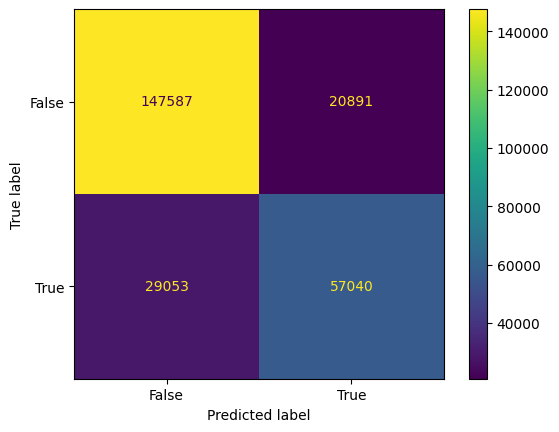

In [75]:
y_train = ds_train.mortality
y_train_hat = tf.squeeze(model.predict(tf_train.batch(512))).numpy()
y_train_hat_classif = y_train_hat > 0.5

ConfusionMatrixDisplay.from_predictions(y_train, y_train_hat_classif)
plt.show()

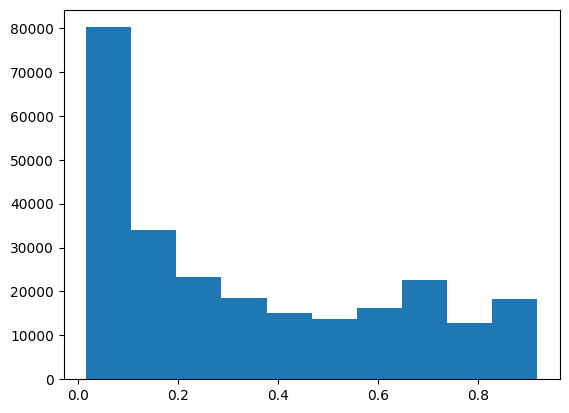

In [76]:
plt.hist(y_train_hat)
plt.show()

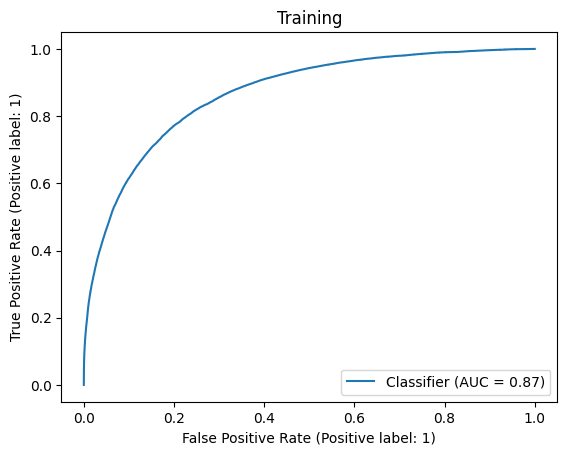

In [77]:
RocCurveDisplay.from_predictions(y_train, y_train_hat)
plt.title("Training")
plt.show()

### Evaluate on test data

71/71 [==============================] - 0s 6ms/step


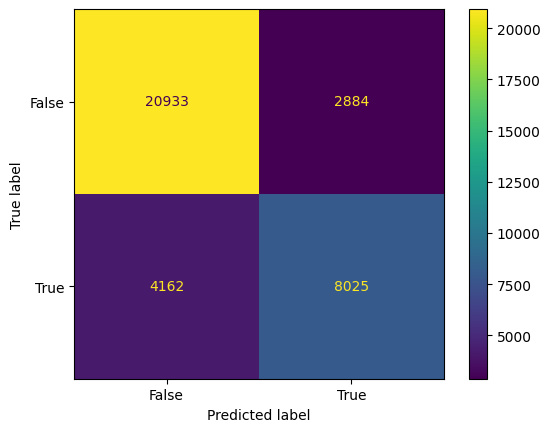

In [78]:
y_test = ds_test.mortality
y_test_hat = tf.squeeze(model.predict(tf_test.batch(512))).numpy()
y_test_hat_classif = y_test_hat > 0.5

ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat_classif)
plt.show()

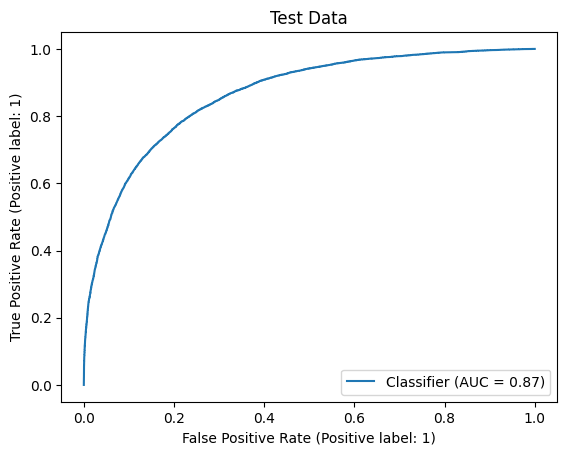

In [79]:
RocCurveDisplay.from_predictions(y_test, y_test_hat)
plt.title("Test Data")
plt.show()

In [80]:
model.save("data_working/models/preisler_classif_noyear.model/")

INFO:tensorflow:Assets written to: data_working/models/preisler_classif_noyear.model/assets


### Prepare for export to Google Cloud

Wrap in serialization and deserialization layers

In [84]:
# From https://github.com/google/earthengine-community/blob/master/guides/linked/Earth_Engine_TensorFlow_Vertex_AI.ipynb
class DeSerializeInput(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, inputs_dict):
    return {
      k: tf.map_fn(lambda x: tf.io.parse_tensor(x, tf.float32),
                   tf.io.decode_base64(v),
                   fn_output_signature=tf.float32)
        for (k, v) in inputs_dict.items()
    }

  def get_config(self):
    config = super().get_config()
    return config


class ReSerializeOutput(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, output_tensor):
    return tf.map_fn(lambda x: tf.io.encode_base64(tf.io.serialize_tensor(x)),
                    output_tensor,
                    fn_output_signature=tf.string)

  def get_config(self):
    config = super().get_config()
    return config

input_deserializer = DeSerializeInput()
output_deserializer = ReSerializeOutput()

serialized_inputs = {
    b: tf.keras.Input(shape=[], dtype='string', name=b) for b in BANDS
}

updated_model_input = input_deserializer(serialized_inputs)
updated_model = model(updated_model_input)
updated_model = output_deserializer(updated_model)
updated_model= tf.keras.Model(serialized_inputs, updated_model)

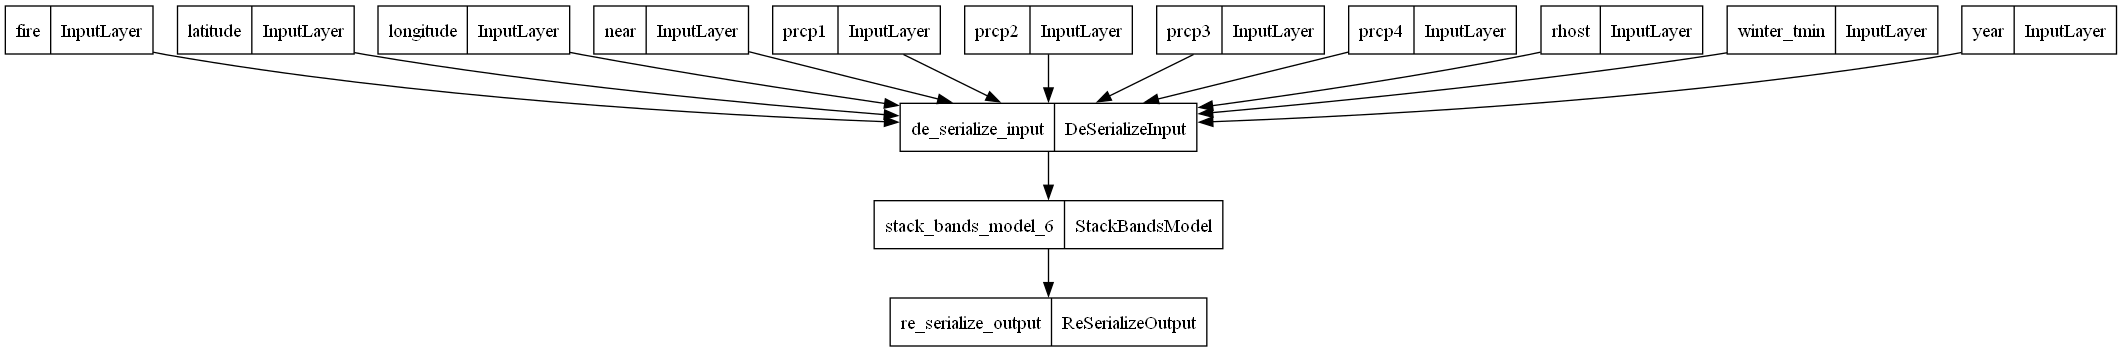

In [85]:
tf.keras.utils.plot_model(updated_model)

In [90]:
# Save trained model
MODEL_DIR = "gs://" + bucket + "/model"

In [91]:
!gsutil rm -r {MODEL_DIR}

CommandException: No URLs matched: gs://preisler_tfdata/model


In [93]:
updated_model.save("data_working/models/preisler_classif_gcloud.tf")

INFO:tensorflow:Assets written to: data_working/models/preisler_classif_gcloud.tf\assets


In [94]:
!gsutil cp -r data_working/models/preisler_classif_gcloud.tf/ gs://{bucket}

Copying file://data_working\models\preisler_classif_gcloud.tf\saved_model.pb [Content-Type=application/octet-stream]...
/ [0 files][    0.0 B/  1.0 MiB]                                                
/ [1 files][  1.0 MiB/  1.0 MiB]                                                
Copying file://data_working\models\preisler_classif_gcloud.tf\keras_metadata.pb [Content-Type=application/octet-stream]...
/ [1 files][  1.0 MiB/  1.1 MiB]                                                
/ [2 files][  1.1 MiB/  1.1 MiB]                                                
-
Copying file://data_working\models\preisler_classif_gcloud.tf\variables\variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
- [2 files][  1.1 MiB/  1.2 MiB]                                                
- [3 files][  1.2 MiB/  1.2 MiB]                                                
Copying file://data_working\models\preisler_classif_gcloud.tf\variables\variables.index [Content-Type=application/octet-stre

### Deploy model
Note this part costs money!

In [1]:
!gcloud ai models upload \
  --artifact-uri=gs://preisler_tfdata/preisler_classif_gcloud.tf \
  --project=forest-lst \
  --region=us-west1 \
  --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-11:latest \
  --description=preisler_demo \
  --display-name=preisler_demo \
  --model-id=preisler_demo

Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Waiting for operation [8838341206749478912]...
.......................done.


Create the endpoint

In [98]:
!gcloud ai endpoints create \
  --display-name=preisler-demo \
  --region=us-west1 \
  --project=forest-lst

^C


Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Waiting for operation [7372788963947315200]...
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Get the endpoint ID

In [2]:
ENDPOINT_ID = !gcloud ai endpoints list \
  --project=forest-lst \
  --region=us-west1 \
  --filter=displayName:preisler-demo \
  --format="value(ENDPOINT_ID.scope())"
ENDPOINT_ID = ENDPOINT_ID[-1]

In [3]:
print(ENDPOINT_ID)

5099592104229732352


Deploy the model

In [4]:
!gcloud ai endpoints deploy-model {ENDPOINT_ID} \
  --project=forest-lst \
  --region=us-west1 \
  --model=preisler_demo \
  --display-name=preisler-demo

Using endpoint [https://us-west1-aiplatform.googleapis.com/]
Waiting for operation [7868941386957979648]...
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### Run model

Pull an image from which the training was derived, pass to model, visualize result.

In [5]:
import ee
import geemap
ee.Initialize()

In [7]:
example_image = ee.Image("projects/forest-lst/assets/preisler-annual-images/2003")

Map = geemap.Map()
Map.addLayer(example_image.select("pct_mortality").gt(0))
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [8]:
endpoint_path = (
    'projects/' + "forest-lst" + '/locations/' + "us-west1" + '/endpoints/' + str(ENDPOINT_ID))

# Connect to the hosted model.
vertex_model = ee.Model.fromVertexAi(
  endpoint=endpoint_path,
  inputTileSize=[1, 1],
  proj=example_image.select("pct_mortality").projection().atScale(4000),
  fixInputProj=True,
  outputBands={'output': {
      'type': ee.PixelType.float(),
      'dimensions': 1
    }
  })

In [10]:
BANDS   = ["fire", "near", "latitude", "longitude", "prcp1", "prcp2", "prcp3", "prcp4", "rhost", "winter_tmin", "year"]
prediction = vertex_model.predictImage(example_image.select(BANDS).float()).arrayFlatten([["predict_mortality"]])

In [12]:
Map = geemap.Map()

Map.addLayer(example_image.select("pct_mortality").gt(0), name="true mortality")
Map.addLayer(prediction, name="model prediction")

Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

### Export model predictions

For display in an EE app.

In [53]:
ic_path = "projects/forest-lst/assets/preisler-annual-images"
annual_images = ee.ImageCollection(ic_path)
img_idxs = annual_images.aggregate_array("system:index").getInfo()

def do_model_prediction(ic, idx):
    img = ee.Image(ic_path+"/"+idx)
    return vertex_model.predictImage(img.select(BANDS).float())\
        .arrayFlatten([["predict_mortality"]])\
        .set("system:time_start", img.get("system:time_start"))\
        .set("system:time_end", img.get("system:time_end"))

annual_image_predict = list(map(lambda x: do_model_prediction(annual_images, x), img_idxs))

In [52]:
!earthengine create collection projects/forest-lst/assets/preisler-annual-image-prediction

In [51]:
!earthengine rm -r projects/forest-lst/assets/preisler-annual-image-prediction

In [54]:
import datetime

def prediction_export_task(img):
    ms = img.get("system:time_start").getInfo()
    year = datetime.datetime.utcfromtimestamp(ms/1000.0).year
    
    return ee.batch.Export.image.toAsset(
        image=img,
        description="preisler-annual-image-prediction-{}".format(year),
        assetId="projects/forest-lst/assets/preisler-annual-image-prediction/{}".format(year),
        scale=4000,
        crs=img.projection()
    )

tasks = [prediction_export_task(img) for img in annual_image_predict]

In [55]:
for t in tasks: t.start()